# 0 - Requirements

In [1]:
import torch
import torchvision
import numpy as np

import os
import matplotlib.pyplot as plt
import time
import copy
from model.ViT_model import ViT_model

In [2]:
import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION', )
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
# call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

__Python VERSION: 3.9.7 (tags/v3.9.7:1016ef3, Aug 30 2021, 20:19:38) [MSC v.1929 64 bit (AMD64)]
__pyTorch VERSION: 1.9.1+cu102
__CUDA VERSION
__CUDNN VERSION: 7605
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0


# 1 - OCT dataset

In [3]:
# Parameters
device = 'cuda:0' if torch.cuda.is_available() else torch.device('cpu')
batch_size = 8
input_size = (192,192)
mean = [.456,.456,.456]
std = [.224,.224,.224]
num_classes = 4

In [4]:
# Load Dataset and Transform
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(input_size),
    torchvision.transforms.Normalize((mean), (std))
])

val_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(input_size),
    torchvision.transforms.Normalize((mean), (std))
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((input_size, input_size)),
    torchvision.transforms.Normalize((mean), (std))
])

label_transform = torchvision.transforms.Lambda(lambda x: torch.as_tensor(x, dtype = torch.long))

image_dataset = {
    'train': torchvision.datasets.ImageFolder(os.getcwd() + "\\input\\OCT2017\\train", train_transform, label_transform),
    'val': torchvision.datasets.ImageFolder(os.getcwd() + "\\input\\OCT2017\\test", val_transform, label_transform),
    'test': torchvision.datasets.ImageFolder(os.getcwd() + "\\input\\OCT2017\\val", test_transform, label_transform)
}

data_loader = {
    x: torch.utils.data.DataLoader(image_dataset[x], batch_size=batch_size,
                                    shuffle=True)
    for x in ['train', 'val', 'test']
}

# Identifications
label2idx = {key:value for key,value in zip(image_dataset['train'].classes,range(num_classes))}
idx2label = {v:k for k,v in label2idx.items()}
dataset_sizes = {tag:len(data_loader[tag].dataset) for tag in ['train','val','test']}

Feature batch shape: torch.Size([8, 3, 192, 192])
Labels batch shape: torch.Size([8])


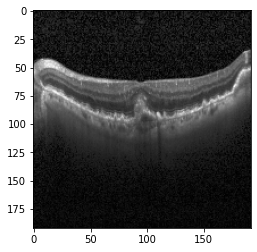

Label: CNV


In [5]:
# Display image and label.
train_features, train_labels = next(iter(data_loader['train']))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(((img.permute(1,2,0).numpy()*std+mean)*255).astype('uint8'), cmap="gray")
plt.show()
print(f"Label: {idx2label[torch.argmax(label).item()]}")

# 2 - Training pipeline

In [6]:
# Model
model = ViT_model(depth = 1,
                  depth_te = 4,
                  linear_list = [4],
                  preprocessing = 'conv',
                  num_patches=144,
                  patch_size = 16,
                  num_channels = 3,
                  hidden_dim = 64,
                  num_heads = 8,
                  attn_drop = .2,
                  proj_drop = .2,
                  linear_drop = .2,
                  dtype = None,
                  )
model.to(device)
#Parameters
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters())
lambda1 = lambda epoch: 0.75 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
print('Num. parameters:',sum(p.numel() for p in model.parameters()))

Architecture information:
Level 0:
	Patch size: 16
	Num. patches: 144
	Projection size: 768
	Hidden dim. size: 64
Level 1:
	Patch size: 8
	Num. patches: 576
	Projection size: 192
	Hidden dim. size: 32
Num. parameters: 3755648


In [ ]:
epochs = 1
steps = 0
running_loss = 0
print_every = 100
train_losses, test_losses = [], []

for epoch in range(epochs):
    for inputs, labels in data_loader['train']:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in data_loader['val']:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = (top_class == labels.view(*top_class.shape))
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(data_loader['train']))
            test_losses.append(test_loss/len(data_loader['val']))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(data_loader['val']):.3f}.. "
                  f"Test accuracy: {accuracy/len(data_loader['val']):.3f}")
            running_loss = 0
            model.train()
#torch.save(model, 'aerialmodel.pth')